In [570]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
%matplotlib inline

## Objective -- create a measure of a stock's forward return

Don't have exact price on day of conference call, but can build a simplified proxy that looks at the stock's return for the subsequent periods after a particular month.

Consistent with rest of analysis, going to build this so we can see absolute return and also return relative to two benchmarks of other stocks (equal_weighted and mkt cap weighted).

In [571]:
# File locations

# Tom's local machine
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

In [572]:
df = pd.read_csv(LIBRARY_PATH+"returns_data.csv")

In [573]:
# Create YearMth column to match the rest of our code
df["Day"], df["Month"], df["Year"] = df["MthEnd"].str.split("-").str
df["YearMth"] = df["Year"] + df["Month"]
df.drop(["MthEnd", "Day", "Month", "Year"], axis = 1, inplace = True)
df["MthFwdReturn"] = df["MthFwdReturn"] / 100
df["CodeYrMth"] = df["Code"] + df["YearMth"]
df.set_index("CodeYrMth", inplace = True)
df

,Code,MthFwdReturn,MthEndMCap,YearMth
CodeYrMth,,,,
AAPL201008,AAPL,0.167215,222087.1,201008
ABBV201008,ABBV,NaN,NaN,201008
ABT201008,ABT,0.058776,76182.4,201008
ACN201008,ACN,0.160929,25983.5,201008
AGN201008,AGN,-0.017646,5378.4,201008
AIG201008,AIG,0.152373,23682.9,201008
ALL201008,ALL,0.143116,14850.7,201008
AMGN201008,AMGN,0.079741,48920.5,201008
AMZN201008,AMZN,0.258191,55902.0,201008


In [574]:
df["MktCap_Wted_Return"] = df["MthFwdReturn"] * df["MthEndMCap"]

In [575]:
benchmarks = df[df["MthFwdReturn"].notnull()]\
             .groupby(df["YearMth"])["MthFwdReturn", "MktCap_Wted_Return"]\
             .sum()

In [576]:
valid_counts = mth_mkt_caps = pd.DataFrame(df[df["MthFwdReturn"].notnull()]\
                                                 .groupby(df["YearMth"])["Code"]\
                                                 .count())

In [577]:
mth_mkt_caps = pd.DataFrame(df[df["MthFwdReturn"].notnull()]\
                                                 .groupby(df["YearMth"])["MthEndMCap"]\
                                                 .sum())

In [578]:
benchmarks = pd.merge(benchmarks, mth_mkt_caps, left_index = True, right_index = True)
benchmarks = pd.merge(benchmarks, valid_counts, left_index = True, right_index = True)

In [579]:
benchmarks["EW_Benchmark"] = (benchmarks["MthFwdReturn"] / benchmarks["Code"])
benchmarks["MW_Benchmark"] = (benchmarks["MktCap_Wted_Return"] / benchmarks["MthEndMCap"])

In [580]:
benchmarks

,MthFwdReturn,MktCap_Wted_Return,MthEndMCap,Code,EW_Benchmark,MW_Benchmark
YearMth,,,,,,
201008,10.485521,5.754896e+05,6724489.7,119,0.088114,0.085581
201009,4.891137,2.851828e+05,7289356.1,119,0.041102,0.039123
201010,-0.148681,-3.902317e+04,7552268.1,119,-0.001249,-0.005167
201011,8.690692,5.153899e+05,7545887.3,120,0.072422,0.068301
201012,2.490882,1.799929e+05,8045258.1,120,0.020757,0.022373
201101,4.216111,2.437175e+05,8251239.9,120,0.035134,0.029537
201102,0.432040,-2.963609e+04,8478599.1,121,0.003571,-0.003495
201103,4.222126,2.368759e+05,8442518.2,121,0.034894,0.028057
201104,-0.956750,-1.277633e+05,8667765.2,121,-0.007907,-0.014740


In [581]:
df = df.merge(benchmarks[["EW_Benchmark", "MW_Benchmark"]], left_on = "YearMth",
             right_index = True, how = "left")
df
# benchmarks[["EW_Benchmark", "MW_Benchmark"]]

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark
CodeYrMth,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581


In [582]:
def add_month(yrmonth, n):
    '''Add n months to a yearmonth field e.g. 201211 + 3 = 201302'''
    year = int(yrmonth[:4])
    month = int(yrmonth[4:])
    if month+n>12:
        year += 1
    month = ((month + n -1 ) % 12 ) + 1
    return str(year) + "{:02d}".format(month)

In [583]:
# Add Monthly Forward Return values for 2 through 6 months
# (note base month is +1 month return, so +1 month = 2 months ahead from month end)
for n in range(2, 7):
    master_vals = df[["Code", "YearMth"]]
    new_ym_field = "CYM_"+str(n)
    master_vals[new_ym_field] = master_vals["Code"]+master_vals["YearMth"].apply(add_month, n = n - 1)
    vals_wanted = pd.DataFrame(df["MthFwdReturn"])
    master_vals = master_vals.merge(vals_wanted, how = "left",
                      left_on = new_ym_field, right_index = True, suffixes = ("_0", "_1"))
    master_vals.rename(columns = {"MthFwdReturn" : "MFR_"+str(n)}, inplace = True)
    master_vals.drop(["Code", "YearMth", "CYM_"+str(n)], axis =1, inplace = True)
    df = df.join(master_vals, how = "left")
    
df
# master_vals
# vals_wanted

/Users/seddont/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,MFR_5,MFR_6
CodeYrMth,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,0.051959,0.040935
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,NaN,NaN
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,-0.048683,0.065102
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,0.061456,0.000194
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,0.055566,0.026963
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,-0.164058,-0.081537
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,-0.023212,0.020552
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,0.003279,-0.068083
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,-0.057556,0.021516


In [584]:
pd.DataFrame(benchmarks.index.values)

,0
0,201008
1,201009
2,201010
3,201011
4,201012
5,201101
6,201102
7,201103
8,201104
9,201105


In [585]:
benchmarks[["EW_Benchmark", "MW_Benchmark"]]

,EW_Benchmark,MW_Benchmark
YearMth,,
201008,0.088114,0.085581
201009,0.041102,0.039123
201010,-0.001249,-0.005167
201011,0.072422,0.068301
201012,0.020757,0.022373
201101,0.035134,0.029537
201102,0.003571,-0.003495
201103,0.034894,0.028057
201104,-0.007907,-0.014740


In [586]:
# Add EW_benchmark and MW_benchmark for +1 through +5 months

for n in range(2, 7):
    master_vals = pd.DataFrame(benchmarks.index.values)
    master_vals.columns = ["YearMth"]
    new_ym_field = "YM_"+str(n)
    master_vals[new_ym_field] = master_vals["YearMth"].apply(add_month, n = n - 1)
    vals_wanted = pd.DataFrame(benchmarks[["EW_Benchmark", "MW_Benchmark"]])
    master_vals = master_vals.merge(vals_wanted, how = "left",
                      left_on = new_ym_field, right_index = True, suffixes = ("_0", "_1"))
    master_vals.rename(columns = {"EW_Benchmark" : "EWB_"+str(n), "MW_Benchmark" : "MWB_"+str(n)}, inplace = True)
    master_vals.set_index("YearMth", inplace = True)
    master_vals.drop([new_ym_field], axis =1, inplace = True)
    df = df.merge(master_vals, how = "left", left_on = "YearMth", right_index = True)
    
df
# master_vals
# vals_wanted

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,...,EWB_2,MWB_2,EWB_3,MWB_3,EWB_4,MWB_4,EWB_5,MWB_5,EWB_6,MWB_6
CodeYrMth,,,,,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,...,0.041102,0.039123,-0.001249,-0.005167,0.072422,0.068301,0.020757,0.022373,0.035134,0.029537


In [587]:
# Calculate compound returns

last_cmp_mfr = df["MthFwdReturn"]
last_cmp_ewb = df["EW_Benchmark"]
last_cmp_mwb = df["MW_Benchmark"]

for n in range(2, 7):
    last_cmp_mfr = (1 + last_cmp_mfr) * (df["MFR_"+str(n)] + 1) - 1
    df["Cmp_MFR_"+str(n)] = last_cmp_mfr
    
    last_cmp_ewb = (1 + last_cmp_ewb) * (df["EWB_"+str(n)] + 1) - 1
    df["Cmp_EWB_"+str(n)] = last_cmp_ewb
    
    last_cmp_mwb = (1 + last_cmp_mwb) * (df["MWB_"+str(n)] + 1) - 1
    df["Cmp_MWB_"+str(n)] = last_cmp_mwb
    
df

,Code,MthFwdReturn,MthEndMCap,YearMth,MktCap_Wted_Return,EW_Benchmark,MW_Benchmark,MFR_2,MFR_3,MFR_4,...,Cmp_MWB_3,Cmp_MFR_4,Cmp_EWB_4,Cmp_MWB_4,Cmp_MFR_5,Cmp_EWB_5,Cmp_MWB_5,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6
CodeYrMth,,,,,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,222087.1,201008,37136.294427,0.088114,0.085581,0.060722,0.033790,0.036670,...,0.122224,0.326861,0.213362,0.198873,0.395803,0.238548,0.225694,0.452940,0.282064,0.261898
ABBV201008,ABBV,NaN,NaN,201008,NaN,0.088114,0.085581,NaN,NaN,NaN,...,0.122224,NaN,0.213362,0.198873,NaN,0.238548,0.225694,NaN,0.282064,0.261898
ABT201008,ABT,0.058776,76182.4,201008,4477.696742,0.088114,0.085581,-0.009483,-0.093726,0.030101,...,0.122224,-0.020949,0.213362,0.198873,-0.068612,0.238548,0.225694,-0.007977,0.282064,0.261898
ACN201008,ACN,0.160929,25983.5,201008,4181.498671,0.088114,0.085581,0.062712,-0.031089,0.119344,...,0.122224,0.338039,0.213362,0.198873,0.420269,0.238548,0.225694,0.420545,0.282064,0.261898
AGN201008,AGN,-0.017646,5378.4,201008,-94.907246,0.088114,0.085581,0.102576,0.044802,0.059705,...,0.122224,0.199211,0.213362,0.198873,0.265846,0.238548,0.225694,0.299977,0.282064,0.261898
AIG201008,AIG,0.152373,23682.9,201008,3608.634522,0.088114,0.085581,0.074425,-0.017139,0.395495,...,0.122224,0.698203,0.213362,0.198873,0.419599,0.238548,0.225694,0.303849,0.282064,0.261898
ALL201008,ALL,0.143116,14850.7,201008,2125.372781,0.088114,0.085581,-0.033597,-0.038750,0.095156,...,0.122224,0.162950,0.213362,0.198873,0.135955,0.238548,0.225694,0.159301,0.282064,0.261898
AMGN201008,AMGN,0.079741,48920.5,201008,3900.969591,0.088114,0.085581,0.037743,-0.078685,0.041943,...,0.122224,0.075627,0.213362,0.198873,0.079154,0.238548,0.225694,0.005682,0.282064,0.261898
AMZN201008,AMZN,0.258191,55902.0,201008,14433.393282,0.088114,0.085581,0.052018,0.061551,0.026226,...,0.122224,0.441961,0.213362,0.198873,0.358968,0.238548,0.225694,0.388207,0.282064,0.261898


In [588]:
# clean up intermediate columns we don't really need
# Just want compound 1, 3, 6 month values

drop_cols = []
for n in range(2, 7):
    drop_cols.extend(["MFR_"+str(n),"EWB_"+str(n),"MWB_"+str(n)])
    
for n in [2,4,5]:
    drop_cols.extend(["Cmp_MFR_"+str(n),"Cmp_EWB_"+str(n),"Cmp_MWB_"+str(n)])
    
drop_cols.extend(["MthEndMCap", "MktCap_Wted_Return"])
    
df.drop(drop_cols, axis = 1, inplace = True)

df
#     drop_cols.append("EWB_"+str(n))
# for m in [1,3,4]:
#     for f in ["MFR, "]
# df.drop([""])

# drop_cols

,Code,MthFwdReturn,YearMth,EW_Benchmark,MW_Benchmark,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6
CodeYrMth,,,,,,,,,,,
AAPL201008,AAPL,0.167215,201008,0.088114,0.085581,0.279926,0.131422,0.122224,0.452940,0.282064,0.261898
ABBV201008,ABBV,NaN,201008,0.088114,0.085581,NaN,0.131422,0.122224,NaN,0.282064,0.261898
ABT201008,ABT,0.058776,201008,0.088114,0.085581,-0.049558,0.131422,0.122224,-0.007977,0.282064,0.261898
ACN201008,ACN,0.160929,201008,0.088114,0.085581,0.195378,0.131422,0.122224,0.420545,0.282064,0.261898
AGN201008,AGN,-0.017646,201008,0.088114,0.085581,0.131646,0.131422,0.122224,0.299977,0.282064,0.261898
AIG201008,AIG,0.152373,201008,0.088114,0.085581,0.216918,0.131422,0.122224,0.303849,0.282064,0.261898
ALL201008,ALL,0.143116,201008,0.088114,0.085581,0.061903,0.131422,0.122224,0.159301,0.282064,0.261898
AMGN201008,AMGN,0.079741,201008,0.088114,0.085581,0.032328,0.131422,0.122224,0.005682,0.282064,0.261898
AMZN201008,AMZN,0.258191,201008,0.088114,0.085581,0.405111,0.131422,0.122224,0.388207,0.282064,0.261898


In [589]:
# rename 1 month columns for consistency
df.rename(columns = {"MthFwdReturn" : "Cmp_MFR_1", 
                     "EW_Benchmark" : "Cmp_EWB_1",
                     "MW_Benchmark" : "Cmp_MWB_1"}, inplace = True)

In [590]:
# calculate compund return relative to benchmark
for n in [1,3,6]:
    df["alpha_ew_"+str(n)] = df["Cmp_MFR_"+str(n)] - df["Cmp_EWB_"+str(n)]
    df["alpha_mw_"+str(n)] = df["Cmp_MFR_"+str(n)] - df["Cmp_MWB_"+str(n)]

In [591]:
df

,Code,Cmp_MFR_1,YearMth,Cmp_EWB_1,Cmp_MWB_1,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6,alpha_ew_1,alpha_mw_1,alpha_ew_3,alpha_mw_3,alpha_ew_6,alpha_mw_6
CodeYrMth,,,,,,,,,,,,,,,,,
AAPL201008,AAPL,0.167215,201008,0.088114,0.085581,0.279926,0.131422,0.122224,0.452940,0.282064,0.261898,0.079101,0.081634,0.148504,0.157702,0.170876,0.191042
ABBV201008,ABBV,NaN,201008,0.088114,0.085581,NaN,0.131422,0.122224,NaN,0.282064,0.261898,NaN,NaN,NaN,NaN,NaN,NaN
ABT201008,ABT,0.058776,201008,0.088114,0.085581,-0.049558,0.131422,0.122224,-0.007977,0.282064,0.261898,-0.029338,-0.026805,-0.180980,-0.171782,-0.290041,-0.269875
ACN201008,ACN,0.160929,201008,0.088114,0.085581,0.195378,0.131422,0.122224,0.420545,0.282064,0.261898,0.072815,0.075348,0.063956,0.073154,0.138481,0.158647
AGN201008,AGN,-0.017646,201008,0.088114,0.085581,0.131646,0.131422,0.122224,0.299977,0.282064,0.261898,-0.105760,-0.103227,0.000224,0.009422,0.017913,0.038079
AIG201008,AIG,0.152373,201008,0.088114,0.085581,0.216918,0.131422,0.122224,0.303849,0.282064,0.261898,0.064259,0.066792,0.085496,0.094694,0.021785,0.041951
ALL201008,ALL,0.143116,201008,0.088114,0.085581,0.061903,0.131422,0.122224,0.159301,0.282064,0.261898,0.055002,0.057535,-0.069519,-0.060321,-0.122762,-0.102596
AMGN201008,AMGN,0.079741,201008,0.088114,0.085581,0.032328,0.131422,0.122224,0.005682,0.282064,0.261898,-0.008373,-0.005840,-0.099094,-0.089896,-0.276382,-0.256216
AMZN201008,AMZN,0.258191,201008,0.088114,0.085581,0.405111,0.131422,0.122224,0.388207,0.282064,0.261898,0.170077,0.172610,0.273689,0.282887,0.106144,0.126310


In [594]:
model_dir = LIBRARY_PATH = "saved_models/topic20_minlength20_base"

with open(model_dir+"/hell_sims.txt", "r") as f:
    scores = json.loads(f.read())

In [595]:
scores

{u'ETR_20110802': {u'13': 0.26174575105958214,
  u'14': 0.6851481491477092,
  u'22': 0.5034241071453505,
  u'26': 0.5214069514009948,
  u'4': 0.24360511062698342,
  u'6': 0.6704420410358952,
  u'8': 0.5705146500946645},
 u'CELG_20160728': {u'1': 0.6032902699300821,
  u'2': 0.5491252124388154,
  u'3': 0.3392722168949353,
  u'7': 0.6247031462075436,
  u'8': 0.46257337213930866},
 u'MO_20151029': {u'0': 0.6514741172488995,
  u'1': 0.25039768709124566,
  u'12': 0.2982029778600752,
  u'15': 0.6035120129965542,
  u'16': 0.2614093174431971,
  u'18': 0.6389557127602249,
  u'19': 0.45095709617358265,
  u'2': 0.5168266077323852,
  u'20': 0.49356002388919323,
  u'5': 0.32728533015219285,
  u'6': 0.5050836781046982,
  u'8': 0.37429106697198056,
  u'9': 0.43186968364208594},
 u'BAC_20160718': {u'11': 0.4728999000140742,
  u'15': 0.4820048155699724,
  u'17': 0.45866531961074275,
  u'2': 0.40882334873605747,
  u'22': 0.2826308209036495,
  u'23': 0.5796127952521117,
  u'24': 0.5178743209111099,
  u'28

In [608]:
# Take a scoring file and turn into a pandas dataframe for joining to the point returns
#
# Scoring file is a dict of dicts -- {"transcript_file": {q_num: score, q_num:score...}, ...}
#
# transcript_file is of form CODE_YEARMTHDAY e.g. ETR_20110802

cym = []
avg_scores = []

for transcript in scores:
    code, long_date = transcript.split("_")
    yearmth = long_date[:6]
    cym.append(code + yearmth)
    avg_scores.append(np.mean([scores[transcript][q] for q in scores[transcript]]))

d = {"CodeYrMth": cym, "Score": avg_scores}
sf = pd.DataFrame(data = d)
sf.set_index("CodeYrMth", inplace = True)
sf

,Score
CodeYrMth,
ETR201108,0.493755
CELG201607,0.515793
MO201510,0.446448
BAC201607,0.463794
RTN201310,0.429066
BA201604,0.489758
XRX201404,0.452931
CMCSA201704,0.420229
AVP201611,0.451643


In [609]:
# Join point return data to scores
sf = sf.join(df, how = "left")
sf

,Score,Code,Cmp_MFR_1,YearMth,Cmp_EWB_1,Cmp_MWB_1,Cmp_MFR_3,Cmp_EWB_3,Cmp_MWB_3,Cmp_MFR_6,Cmp_EWB_6,Cmp_MWB_6,alpha_ew_1,alpha_mw_1,alpha_ew_3,alpha_mw_3,alpha_ew_6,alpha_mw_6
CodeYrMth,,,,,,,,,,,,,,,,,,
ETR201108,0.493755,ETR,0.016562,201108,-0.077519,-0.060493,0.091974,0.032637,0.033644,0.046637,0.140967,0.145012,0.094081,0.077055,0.059337,0.058330,-0.094330,-0.098375
CELG201607,0.515793,CELG,-0.048578,201607,0.005308,0.002329,-0.089224,-0.004252,-0.009440,0.035297,0.085231,0.060120,-0.053886,-0.050907,-0.084973,-0.079784,-0.049933,-0.024823
MO201510,0.446448,MO,-0.047462,201510,-0.000487,0.004029,0.020467,-0.077620,-0.052082,0.056726,0.026124,0.003074,-0.046975,-0.051491,0.098088,0.072549,0.030603,0.053652
BAC201607,0.463794,BAC,0.119048,201607,0.005308,0.002329,0.144008,-0.004252,-0.009440,0.575293,0.085231,0.060120,0.113740,0.116719,0.148260,0.153449,0.490063,0.515174
RTN201310,0.429066,RTN,0.076606,201310,0.026627,0.032584,0.161203,0.024806,0.019274,0.173353,0.090059,0.079935,0.049979,0.044022,0.136396,0.141929,0.083294,0.093418
BA201604,0.489758,BA,-0.056500,201604,0.005126,0.017654,-0.000331,0.047544,0.058312,0.074040,0.043090,0.048321,-0.061626,-0.074154,-0.047875,-0.058643,0.030950,0.025719
XRX201404,0.452931,XRX,0.021505,201404,0.031861,0.024821,0.102328,0.044657,0.034571,0.109214,0.093811,0.085956,-0.010356,-0.003316,0.057671,0.067757,0.015403,0.023258
CMCSA201704,0.420229,CMCSA,0.063792,201704,-0.001518,0.012472,0.036328,0.034059,0.038451,-0.073116,0.073126,0.091864,0.065310,0.051320,0.002268,-0.002123,-0.146242,-0.164980
AVP201611,0.451643,AVP,-0.061453,201611,0.015320,0.022895,-0.180633,0.076489,0.085788,-0.366853,0.077331,0.116280,-0.076773,-0.084348,-0.257122,-0.266422,-0.444184,-0.483133


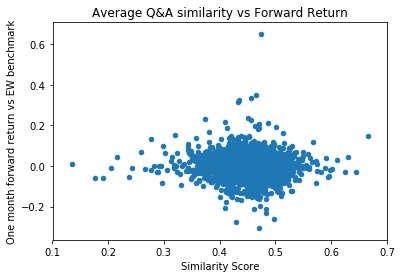

In [614]:
# quick visualization
sf.plot(kind = "scatter", x = "Score", y = "alpha_ew_1")
plt.title("Average Q&A similarity vs Forward Return")
plt.xlabel("Similarity Score")
plt.ylabel("One month forward return vs EW benchmark")

In [624]:
# Run single variable OLS

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

results = smf.ols("alpha_ew_1 ~ Score", data = sf).fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:             alpha_ew_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5518
Date:                Tue, 12 Dec 2017   Prob (F-statistic):              0.458
Time:                        15:28:37   Log-Likelihood:                 4397.2
No. Observations:                2899   AIC:                            -8790.
Df Residuals:                    2897   BIC:                            -8778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0081      0.010      0.769      0.4

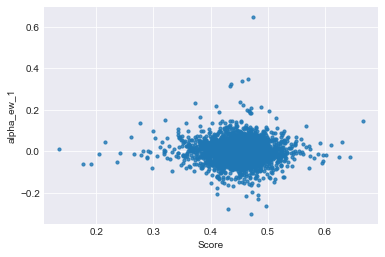

In [638]:
sns.set_style("darkgrid")
sns.regplot(x = "Score", y = "alpha_ew_1", data = sf, fit_reg = False, 
            scatter_kws={"s": 10}, lowess = True)

In [635]:
# Try a model more robust to outliers...

results = smf.rlm("alpha_ew_1 ~ Score", data = sf).fit()
print results.summary()

                    Robust linear Model Regression Results                    
Dep. Variable:             alpha_ew_1   No. Observations:                 2899
Model:                            RLM   Df Residuals:                     2897
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 12 Dec 2017                                         
Time:                        15:37:22                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0047      0.009      0.528      0.5